In [1]:
import astropy.io.fits as pyfits

import glob

In [2]:
#from types import *
#print(dir())

#def expfunc(p, ydata, x):
#    A,B,C = p
#    y = A*np.exp(B*x)+C
#    return y - ydata

def expfunc(p, ydata, x):
    a0,a1,a2 = p
    y = a0*a1**x + a2
    return y - ydata

def poly_n(p, ydata, x):
    p = np.array(p)
    if type(x) == float: y = 0
    else: y = np.zeros((x.shape[0],))
    for n in np.arange(p.shape[0]):
        y += p[n]*x**n
    return y - ydata
    
    

In [3]:
all_direct = glob.glob("test/Roman_test*direct.fits")
all_slitless = glob.glob("test/Roman_test*slitless.fits")
#all_direct = glob.glob("../OUTSIM/WFC3_test*direct.fits")
#all_slitless = glob.glob("../OUTSIM/WFC3_test*slitless.fits")
print(all_direct)
print(all_slitless)

['test/Roman_test_single_v2_direct.fits', 'test/Roman_test_full_v2_direct.fits']
['test/Roman_test_single_v2_slitless.fits', 'test/Roman_test_full_v2_slitless.fits']


In [4]:
#all_direct = ["test/Roman_test_single_v2_direct.fits"]
all_direct = ["test/Roman_test_full_v2_direct.fits"]
#all_direct = ["test/WFC3_test_single_v2_direct.fits"]

In [5]:
for direct in all_direct:
    print(direct)
    hdu = pyfits.open(direct)
    hdu.info()
    h0 = hdu[0]
    head0 = h0.header
    print("EXPTIME =",head0['EXPTIME'])
    
    h1 = hdu['SCI']
    head = h1.header
    image = h1.data
    
    h2 = hdu['ERR']
    err = h2.data

test/Roman_test_full_v2_direct.fits
Filename: test/Roman_test_full_v2_direct.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  SCI           1 ImageHDU        71   (4096, 4096)   float32   
  2  ERR           1 ImageHDU        71   (4096, 4096)   float32   
  3  DQ            1 ImageHDU        35   (4096, 4096)   int32   
EXPTIME = 1128.0


In [6]:
from astropy.stats import sigma_clipped_stats

mean, median, std = sigma_clipped_stats(image, sigma=3.0)  
print((mean, median, std))
#mean, median, std = sigma_clipped_stats(image, sigma=5.0)  
#print((mean, median, std))
#mean, median, std = sigma_clipped_stats(image, sigma=10.0)  
#print((mean, median, std))

(1.0600491e-05, 1.1010594e-05, 0.013969935)


In [7]:
wav = 1.5e-6 # m
D_tele = 2.4 # m
pixel_scale = 0.11 # arcsec/pixel

theta = wav/D_tele   # radians
theta_arc = theta*206265 # arcsec
print(theta)
print(theta_arc) # SExtractor FWHM
fwhm = theta_arc/pixel_scale # pixels
print(fwhm)

6.25e-07
0.128915625
1.1719602272727274


In [8]:
from photutils.detection import DAOStarFinder 
daofind = DAOStarFinder(fwhm=10.0, threshold=5.0*std, roundlo=-1.5, roundhi=1.5) 

sources = daofind(image - median)
for col in sources.colnames:  
     sources[col].info.format = '%.8g'  # for consistent table output
print(sources)  

 id xcentroid ycentroid sharpness  ... sky     peak       flux       mag     
--- --------- --------- ---------- ... --- ----------- --------- ------------
  1 2046.9984 254.99123 0.63945844 ...   0   10.684435 408.51524   -6.5280207
  2 2046.9965 383.00529  0.6100232 ...   0   4.1333842 164.33012   -5.5392929
  3 1590.5913    448.81 0.44534165 ...   0 0.015197949 1.0962978 -0.099821372
  4 2047.0024 510.98909 0.64715623 ...   0    1.741469 66.314564   -4.5540223
  5 2047.0074 638.91017  0.6819556 ...   0  0.72591257 26.617049   -3.5628998
  6 2046.9927 767.11641 0.73429246 ...   0  0.30707744 10.618966   -2.5652056
  7 2046.9726 895.12878 0.58516365 ...   0  0.10653768 4.4647813   -1.6245005
  8 2047.0283 1023.0489 0.75144624 ...   0 0.053321064 1.8261428  -0.65383686


NUMBER X_IMAGE Y_IMAGE A_IMAGE B_IMAGE ... MAG_F1600W  Z  SPECTEMP MODIMAGE
------ ------- ------- ------- ------- ... ---------- --- -------- --------
     1    2048     256     2.0     2.0 ...       20.0 0.0        0        0
     2    2048     384     2.0     2.0 ...       21.0 0.0        0        0
     3    2048     512     2.0     2.0 ...       22.0 0.0        0        0
     4    2048     640     2.0     2.0 ...       23.0 0.0        0        0
     5    2048     768     2.0     2.0 ...       24.0 0.0        0        0
     6    2048     896     2.0     2.0 ...       25.0 0.0        0        0
     7    2048    1024     2.0     2.0 ...       26.0 0.0        0        0
     8    2048    1152     2.0     2.0 ...       27.0 0.0        0        0
     9    2048    1280     2.0     2.0 ...       28.0 0.0        0        0
    10    2048    1408     2.0     2.0 ...       29.0 0.0        0        0
    11    2048    1536     2.0     2.0 ...       30.0 0.0        0        0


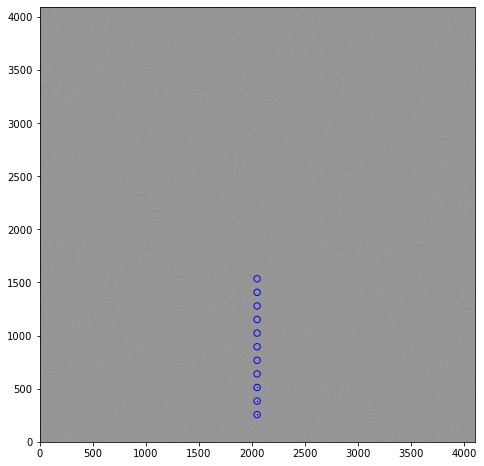

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture
from astropy.table import Table

input = Table.read("../save/test_test.lis", format='ascii.sextractor')
print(input)

# correcting for indexing starting at 1
positions = np.transpose((input['X_IMAGE']-1, input['Y_IMAGE']-1))


# from detections, problem detecting fainter sources
#positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

apertures = CircularAperture(positions, r=30.)

fig = plt.figure(figsize=(8,8))
p1 = fig.add_subplot(111)
p1.imshow(image, cmap='Greys', origin='lower',
           interpolation='nearest',vmin=-1,vmax=1)
apertures.plot(color='blue', lw=1, alpha=1)


In [11]:
import numpy as np
from photutils.aperture import aperture_photometry

rmin = 1
rmax = 14
rinc = 1
radii = np.arange(rmin,rmax,rinc)
apertures = [CircularAperture(positions, r=r) for r in radii]
phot_table = aperture_photometry(image, apertures)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.6g'  # for consistent table output
print(phot_table)

 id xcenter ycenter ... aperture_sum_10 aperture_sum_11 aperture_sum_12
      pix     pix   ...                                                
--- ------- ------- ... --------------- --------------- ---------------
  1    2047     255 ...         326.316          326.18         326.186
  2    2047     383 ...          129.95         129.967         129.853
  3    2047     511 ...         51.6424         51.5575         51.6447
  4    2047     639 ...         20.4772         20.5398          20.538
  5    2047     767 ...         8.36471         8.41448         8.43912
  6    2047     895 ...         3.15375         3.05916         3.05571
  7    2047    1023 ...         1.57515         1.56965         1.74926
  8    2047    1151 ...        0.586295        0.367482        0.280369
  9    2047    1279 ...       -0.207375       -0.255793       -0.246103
 10    2047    1407 ...      -0.0019848       -0.203043       -0.383319
 11    2047    1535 ...      -0.0416589      -0.0302127      -0.

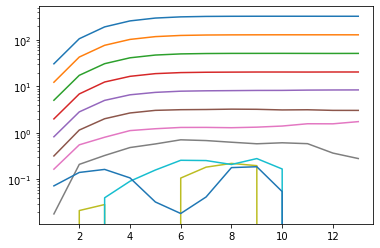

In [12]:
fig = plt.figure()
p1 = fig.add_subplot(111)
for idx in range(len(phot_table)):
    flux = [phot_table[idx]['aperture_sum_%i' % i] for i in np.arange(rmin-1,rmax-1,rinc)]
    p1.plot(radii,flux)
    
p1.set_yscale("log")

In [13]:
from photutils.aperture import CircularAnnulus

aperture = CircularAperture(positions, r=9)
annulus_aperture = CircularAnnulus(positions, r_in=13., r_out=17.)

apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(image, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id xcenter ycenter aperture_sum_0 aperture_sum_1
      pix     pix                                
--- ------- ------- -------------- --------------
  1    2047     255      326.39162    -0.18865333
  2    2047     383      129.86636   -0.074789309
  3    2047     511      51.714487    -0.33318859
  4    2047     639      20.506892   -0.040686754
  5    2047     767      8.2261769      0.1007454
  6    2047     895      3.2262054     0.08082717
  7    2047    1023      1.3299443     0.41628002
  8    2047    1151     0.58321287    0.084411245
  9    2047    1279     0.19692975     0.38312433
 10    2047    1407      0.2797542     0.13196617
 11    2047    1535     0.18670488   -0.056336811


In [14]:
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area

In [15]:
bkg_sum = bkg_mean * aperture.area
final_sum = phot_table['aperture_sum_0'] - bkg_sum
phot_table['residual_aperture_sum'] = final_sum
phot_table['residual_aperture_sum'].info.format = '%.8g'  # for consistent table output
print(phot_table['residual_aperture_sum']) 

residual_aperture_sum
---------------------
            326.51897
            129.91684
             51.93939
            20.534355
            8.1581737
            3.1716471
            1.0489553
           0.52623528
         -0.061679172
           0.19067704
           0.22473223


In [16]:
phot_table['mag'] = input['MAG_F1600W']
#phot_table['mag'] = np.array([20,21,22,23])

mag =  27.0 [AB]
2047.0
1151.0


(1126.0, 1176.0)

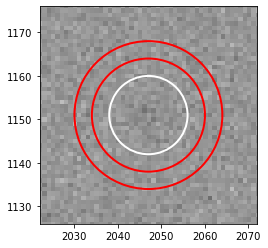

In [17]:
ind = 7 # source number
print("mag = ",phot_table['mag'][ind],"[AB]")

fig = plt.figure(figsize=(4,4))
p1 = fig.add_subplot(111)
p1.imshow(image, cmap='Greys', origin='lower',
            interpolation='nearest',vmin=-0.2,vmax=0.2)
aperture.plot(color='white', lw=2, alpha=1)
annulus_aperture.plot(color='red', lw=2, alpha=1)

xpos = phot_table['xcenter'][ind].value
ypos = phot_table['ycenter'][ind].value
print(xpos)
print(ypos)

p1.set_xlim(xpos-25,xpos+25)
p1.set_ylim(ypos-25,ypos+25)


In [18]:
#exptime = 141.
exptime = 1128.

# m = -2.5*np.log(flux) + zp
# zp = m + 2.5*np.log(flux)

# according to the WFC3 tests aXeSIM output is wrong, should be divided by the exptime
# background seems right, considering it is in e/s 

# 2022.0115
# --> this could be related to the mag being mag_160 instead of mag_1600 (which is correct)

#    [AB]                             [e/s]
zp = phot_table['mag'] + 2.5*np.log10(phot_table['residual_aperture_sum'])
#zp = phot_table['mag'] + 2.5*np.log10(phot_table['residual_aperture_sum']/exptime)


print(zp)
print(phot_table['residual_aperture_sum'])
print(phot_table['residual_aperture_sum']/exptime)
print(phot_table['mag'])

       mag        
------------------
 26.28477103118595
26.284163661683298
 26.28874210256808
26.281202689672885
26.278982373927324
26.253212149921723
26.051892466426015
26.302949893564865
               nan
 27.20074599354897
28.379163408440842
residual_aperture_sum
---------------------
            326.51897
            129.91684
             51.93939
            20.534355
            8.1581737
            3.1716471
            1.0489553
           0.52623528
         -0.061679172
           0.19067704
           0.22473223
residual_aperture_sum
---------------------
           0.28946717
           0.11517451
          0.046045558
          0.018204216
         0.0072324235
         0.0028117439
        0.00092992492
        0.00046652063
       -5.4680117e-05
        0.00016903993
         0.0001992307
mag 
----
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0


/Users/gwalth/python/miniconda3/envs/gwalth3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


It would be nice to have EXPTIME and BUNIT in the aXeSIM header!

In [19]:
# m = -2.5*log10(flux) + zp
#zp = 31.28
zp = 26.285 
m = 20
flux = 10**(0.4*(zp - m))
print(flux) # [e/s]

326.587832172336


In [20]:
from scipy.optimize import leastsq

flux = phot_table['residual_aperture_sum'][:-3]
mag = -2.5*np.log10(phot_table['residual_aperture_sum'][:-3]) + zp
filt = np.logical_not(np.isnan(mag))
print(flux[filt])
print(mag[filt])

#param = [1,1,1]
#sol = leastsq(expfunc,param,args=(np.log10(flux[filt]),mag[filt]),full_output=1)

param = [1,1]
sol = leastsq(poly_n,param,args=(np.log10(flux[filt]),mag[filt]),full_output=1)
print(sol[0])

residual_aperture_sum
---------------------
            326.51897
            129.91684
             51.93939
            20.534355
            8.1581737
            3.1716471
            1.0489553
           0.52623528
residual_aperture_sum
---------------------
            20.000229
            21.000836
            21.996258
            23.003797
            24.006018
            25.031788
            26.233108
             26.98205
[10.514 -0.4  ]


Text(0, 0.5, 'log$_{10}$(Flux [e/s])')

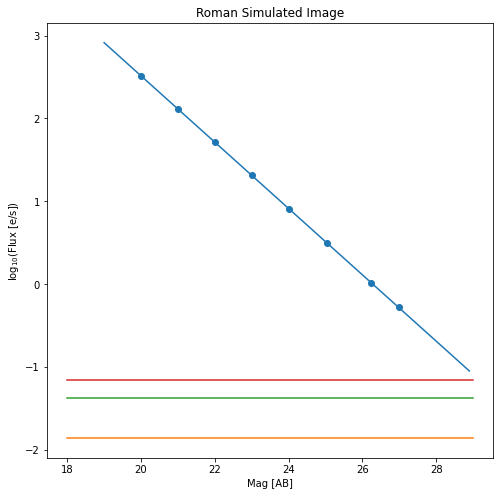

In [22]:
fig = plt.figure(figsize=(8,8))
p1 = fig.add_subplot(111)
p1.scatter(mag[filt],np.log10(flux[filt]))

xfit = np.arange(19,29.0,0.1)
#yfit = expfunc(sol[0],0,xfit)
yfit = poly_n(sol[0],0,xfit)

p1.plot(xfit,yfit)

p1.plot([18,29],[np.log10(std)  ,np.log10(std)])
p1.plot([18,29],[np.log10(3*std),np.log10(3*std)])
p1.plot([18,29],[np.log10(5*std),np.log10(5*std)])

p1.set_title("Roman Simulated Image")
p1.set_xlabel("Mag [AB]")
p1.set_ylabel("log$_{10}$(Flux [e/s])")

# HST S/N calc 

In [23]:
# https://etc.stsci.edu/etc/input/wfc3ir/imaging/
# From WFC3/IR
# F160W
mag = np.array([20,21,22,23,24,25,26,27,28])
peak_flux = np.array([ 70.6, 28.7, 12.0,  5.3,  2.7,  1.6,  1.2,  1.0,  1.0])
flux      = np.array([151.4, 60.3, 24.0,  9.6,  3.8,  1.5,  0.6,  0.2,  0.1])

exptime_single = 141
S_N_single = np.array([137.6,  80.3,  43.3,  21.1,   9.4,   3.9,  1.6,  0.6,  0.3])

exptime_full   = 1128
S_N_full   = np.array([401.9, 243.7, 140.9,  75.0,  36.1,  15.9,  6.6,  2.7,  1.1])

In [24]:
def plot_sn(S_N):
    fig = plt.figure(figsize=(16,5))
    p1 = fig.add_subplot(131)
    p1.scatter(mag,S_N)
    p1.plot([20,28],[5,5])
    p1.plot([20,28],[3,3])
    p1.plot([20,28],[1,1])
    p1.set_xlabel("Mag [AB]")
    p1.set_ylabel("S/N")
    p1.set_yscale("log")

    p2 = fig.add_subplot(132)
    #p2.scatter(mag,flux)
    p2.errorbar(mag,flux,yerr=flux/S_N)
    p2.set_xlabel("Mag [AB]")
    p2.set_ylabel("Flux [e-/s]")
    p2.set_yscale("log")
    print("Noise estimate =", flux/S_N,"[e-/s]")

    p3 = fig.add_subplot(133)
    p3.scatter(mag,peak_flux)
    p3.set_xlabel("Mag [AB]")
    p3.set_ylabel("Peak flux [e-/s]")
    p3.set_yscale("log")


Noise estimate = [1.1002907  0.750934   0.55427252 0.4549763  0.40425532 0.38461538
 0.375      0.33333333 0.33333333] [e-/s]
Noise estimate = [0.37671062 0.24743537 0.17033357 0.128      0.10526316 0.09433962
 0.09090909 0.07407407 0.09090909] [e-/s]


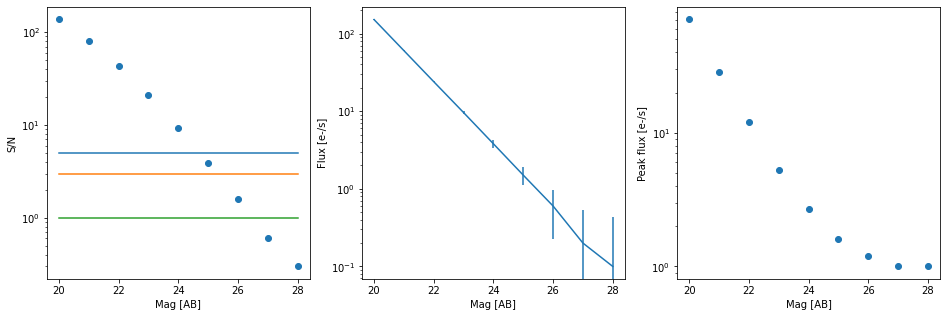

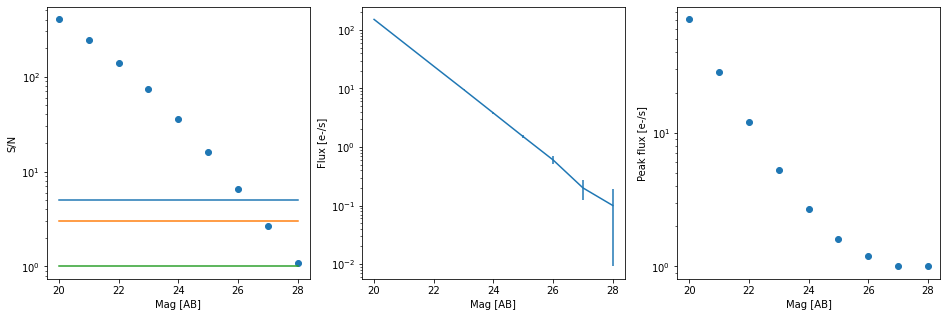

In [35]:
plot_sn(S_N_single)
plot_sn(S_N_full)

In [ ]:
# Testing proceedure
# cd /Users/gwalth/data/Roman/grizli/my_roman_sims/Prep
# ds9 Roman_ptg01_WFI_G150_small_direct.fits Roman_ptg01_WFI_G150_small_direct_new.fits

# /Users/gwalth/data/HST/grizli/CUBS/j011424m4124/Prep
# ds9 j011424m4124-f160w_drz_sci.fits idnc-044.0-g102_drz_sci.fits idnc-044.0-g141_drz_sci.fits  

## WFC3-IR comparison (CUBS parallel vs aXeSIM)

In [26]:
def hst_phot(photflam,photplam,dn,dn_err=None,unit="Jy"):
    ## http://www.stsci.edu/hst/acs/analysis/zeropoints
    ABMAG_ZP=-2.5*np.log10(photflam)-5*np.log10(photplam)-2.408
    print("%.1f" % (photplam),)
    #print("ABMAG_ZP =", ABMAG_ZP)
    m = -2.5*np.log10(dn) + ABMAG_ZP
    #print(m)
    #C = photflam                              # erg/s/cm^2/Ang
    #C = photflam/Ang*(photplam*Ang)**2/c      # erg/s/cm^2/Hz
    C = photflam/Ang*(photplam*Ang)**2/c/Jy   # Jy
    if unit == "Jy": Fnu = dn*C
    elif unit == "mJy": Fnu = dn*C/mJy
    elif unit == "uJy": Fnu = dn*C/uJy
    ABmag = -2.5*np.log10(Fnu*Jy) - 48.60
    print("%.3f" % (ABmag),)
    if dn_err:
        if unit == "Jy": Fnu_err = dn_err*C
        elif unit == "mJy": Fnu_err = dn_err*C/mJy
        elif unit == "uJy": Fnu_err = dn_err*C/uJy

        ABmag_err = 2.5*(Fnu_err/(Fnu*np.log(10)))
        print("%.3f" % (ABmag_err))


        #print("%.4f %.6e %.6e" % (photplam/1E4,Fnu,Fnu_err))
        #print("%.6e %.6e" % (Fnu,Fnu_err))
        return Fnu,Fnu_err
    else:
        #print("%.6e" % Fnu)
        print()
        return Fnu

In [27]:
all_direct = ["/Users/gwalth/data/HST/grizli/CUBS/j011424m4124/Prep/j011424m4124-f160w_drz_sci.fits"]

In [28]:
ext=0
for direct in all_direct:
    print(direct)
    hdu = pyfits.open(direct)
    hdu.info()
    
    h0 = hdu[ext]
    head = h0.header
    image = h0.data
    
    photplam = head["photplam"]
    photflam = head["photflam"]
    
    #h2 = hdu['ERR']
    #err = h2.data

/Users/gwalth/data/HST/grizli/CUBS/j011424m4124/Prep/j011424m4124-f160w_drz_sci.fits
Filename: /Users/gwalth/data/HST/grizli/CUBS/j011424m4124/Prep/j011424m4124-f160w_drz_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     887   (4342, 4428)   float32   
  1  HDRTAB        1 BinTableHDU    559   5R x 275C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, K, 9A, 9A, 7A, 18A, D, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, K, K, D, 3A, D, D, D, D, K, K, 8A, 23A, 11A, 18A, 4A, D, D, K, K, D, D, D, D, 23A, D, D, D, D, K, K, D, 3A, 4A, L, D, D, D, 23A, 1A, D, D, D, D, D, D, 12A, 12A, 8A, 23A, D, D, 10A, 10A, D, D, D, 2A, 3A, 3A, 4A, 8A, 7A, D, K, D, 6A, 9A, D, D, D, 4A, 18A, 3A, K, 5A, D, D, D, 8A, D, 3A, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, L, 1A, 4A, D, 3A, 6A, D, D, D, D, D, 23A, D, D, D, D, D, 1A, K, K, K, K, 8A, 23A, K, K, 10A, 7A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 13A, D, 24A, 23A, D, 1A, 1A, D, K, D, D, 1

In [29]:
from astropy.stats import sigma_clipped_stats

mean, median, std = sigma_clipped_stats(image, sigma=3.0)  
print((mean, median, std))
#mean, median, std = sigma_clipped_stats(image, sigma=5.0)  
#print((mean, median, std))
#mean, median, std = sigma_clipped_stats(image, sigma=10.0)  
#print((mean, median, std))

(3.0261413e-06, 0.0, 0.0013585973)


In [30]:
wav = 1.6e-6 # m
D_tele = 2.4 # m
pixel_scale = 1.66666666666666E-05*3600.  # arcsec/pixel
print(pixel_scale)

theta = wav/D_tele   # radians
theta_arc = theta*206265 # arcsec
print(theta)
print(theta_arc) # FWHM of HST
fwhm = theta_arc/pixel_scale # pixels
print(fwhm)

0.05999999999999976
6.666666666666667e-07
0.13751000000000002
2.2918333333333427


In [31]:
from photutils.detection import DAOStarFinder
#daofind = DAOStarFinder(fwhm=fwhm, threshold=5.3*std, roundlo=-1.5, roundhi=1.5)  
daofind = DAOStarFinder(fwhm=fwhm, threshold=100*std, roundlo=-1.5, roundhi=1.5) 
sources = daofind(image - median)  
for col in sources.colnames:  
     sources[col].info.format = '%.8g'  # for consistent table output
print(len(sources))  

152


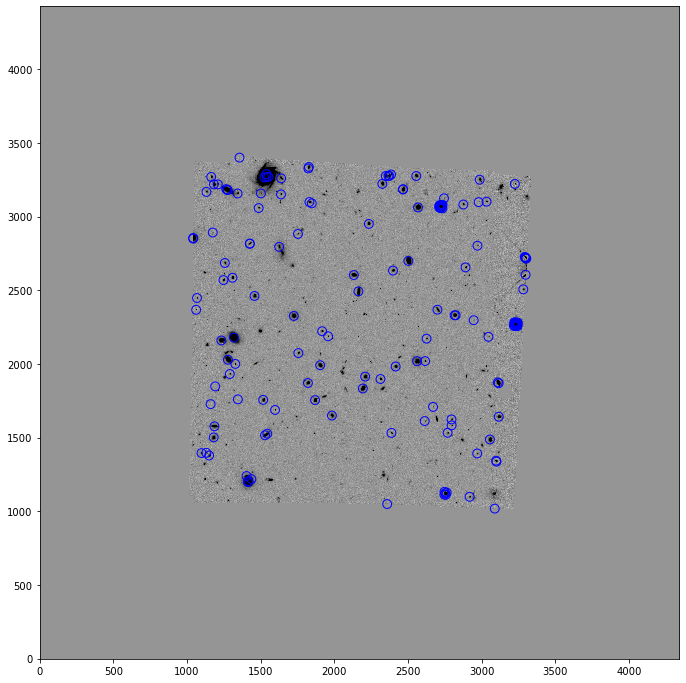

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=30.)

fig = plt.figure(figsize=(12,12))
p1 = fig.add_subplot(111)
p1.imshow(image, cmap='Greys', origin='lower',
            interpolation='nearest',vmin=-0.1,vmax=0.1)
apertures.plot(color='blue', lw=1, alpha=1)

In [33]:
from photutils.aperture import CircularAnnulus

aperture = CircularAperture(positions, r=9)
annulus_aperture = CircularAnnulus(positions, r_in=13., r_out=17.)

apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(image, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1
       pix       pix                                 
--- --------- --------- -------------- --------------
  1 3088.4527 1019.0045     0.70083854     -0.2285862
  2 2358.2758 1050.0183      5.5464064     0.53578303
  3 2917.6132 1099.1909      17.461528      1.9494731
  4 2746.7522 1113.4205      127.11227      109.75833
  5 2756.8357 1113.3447      130.64934      89.145468
  6 2752.0343 1123.2812      652.77442      14.487219
...       ...       ...            ...            ...
146 2555.5239 3277.0029      71.469103      7.9017427
147 2366.9178 3277.1138       48.11254      25.215101
148 2384.7043 3286.8885      29.147777      23.233428
149  1539.262 3289.5595       286.4881      408.00644
150 1823.1489 3328.0029      28.974504      14.511907
151 1826.7949 3338.1373      46.265385      8.4511315
152 1355.7337 3401.6259      2.2677969    -0.20704302
Length = 152 rows


In [34]:
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area

In [35]:
bkg_sum = bkg_mean * aperture.area
final_sum = phot_table['aperture_sum_0'] - bkg_sum
phot_table['residual_aperture_sum'] = final_sum
phot_table['residual_aperture_sum'].info.format = '%.8g'  # for consistent table output
print(phot_table['residual_aperture_sum']) 

residual_aperture_sum
---------------------
           0.85513422
            5.1847528
            16.145633
            53.025402
            70.476148
            642.99554
            16.131067
                  ...
            66.135426
            31.092347
            13.465213
            11.083757
            19.178966
            40.560871
            2.4075509
Length = 152 rows


In [36]:
ABMAG_ZP=-2.5*np.log10(photflam)-5*np.log10(photplam)-2.408
print(ABMAG_ZP)

25.946227204106755


0.0013585973
residual_aperture_sum
---------------------
            26.116141
            24.159407
            22.926089
            21.635017
            21.326122
            18.925707
            22.927069
                  ...
            21.395142
            22.214593
            23.123194
             23.33451
            22.739164
            21.925959
            24.992288
Length = 152 rows
residual_aperture_sum
---------------------
           0.85513422
            5.1847528
            16.145633
            53.025402
            70.476148
            642.99554
            16.131067
                  ...
            66.135426
            31.092347
            13.465213
            11.083757
            19.178966
            40.560871
            2.4075509
Length = 152 rows


/Users/gwalth/python/miniconda3/envs/gwalth3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


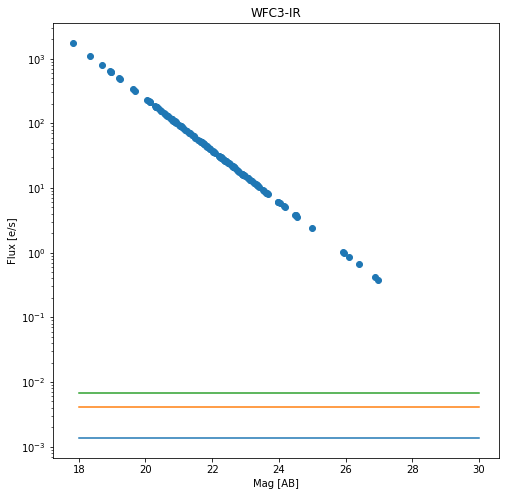

In [51]:
exptime = 1464.69

print(std)

# m = -2.5*np.log(flux) + zp
m = -2.5*np.log10(phot_table['residual_aperture_sum']) + ABMAG_ZP

print(m)
print(phot_table['residual_aperture_sum'])
#print(phot_table['residual_aperture_sum']/exptime)
#print(phot_table['mag'])

fig = plt.figure(figsize=(8,8))
p1 = fig.add_subplot(111)
p1.scatter(m,phot_table['residual_aperture_sum'])
p1.plot([18,30],[std,std])
p1.plot([18,30],[3*std,3*std])
p1.plot([18,30],[5*std,5*std])

p1.set_title("WFC3-IR")
p1.set_xlabel("Mag [AB]")
p1.set_ylabel("Flux [e/s]")
p1.set_yscale("log")

In [44]:
from scipy.optimize import leastsq

flux = phot_table['residual_aperture_sum']
mag = -2.5*np.log10(phot_table['residual_aperture_sum']) + ABMAG_ZP
filt = np.logical_not(np.isnan(mag))
print(flux[filt])
print(mag[filt])

#param = [1,1,1]
#sol = leastsq(expfunc,param,args=(np.log10(flux[filt]),mag[filt]),full_output=1)

param = [1,1]
sol = leastsq(poly_n,param,args=(np.log10(flux[filt]),mag[filt]),full_output=1)
print(sol[0])

residual_aperture_sum
---------------------
           0.85513422
            5.1847528
            16.145633
            53.025402
            70.476148
            642.99554
            16.131067
                  ...
            66.135426
            31.092347
            13.465213
            11.083757
            19.178966
            40.560871
            2.4075509
Length = 136 rows
residual_aperture_sum
---------------------
            26.116141
            24.159407
            22.926089
            21.635017
            21.326122
            18.925707
            22.927069
                  ...
            21.395142
            22.214593
            23.123194
             23.33451
            22.739164
            21.925959
            24.992288
Length = 136 rows
[10.37849088 -0.4       ]


/Users/gwalth/python/miniconda3/envs/gwalth3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


Text(0, 0.5, 'log$_{10}$(Flux [e/s])')

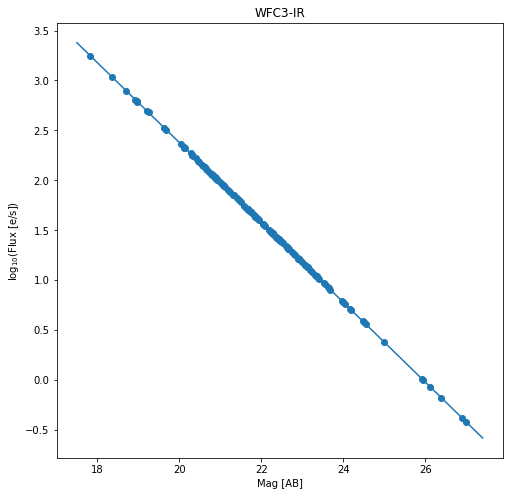

In [50]:
fig = plt.figure(figsize=(8,8))
p1 = fig.add_subplot(111)
p1.scatter(mag[filt],np.log10(flux[filt]))

xfit = np.arange(17.5,27.5,0.1)
#yfit = expfunc(sol[0],0,xfit)
yfit = poly_n(sol[0],0,xfit)

p1.plot(xfit,yfit)
p1.set_title("WFC3-IR")
p1.set_xlabel("Mag [AB]")
p1.set_ylabel("log$_{10}$(Flux [e/s])")